In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import datetime

In [3]:
color_scheme1 = plt.cm.get_cmap('tab20c')
color_scheme2 = plt.cm.get_cmap('tab20c')

In [4]:
fig_size = (13, 8)

In [5]:
now  = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [6]:
xl_writer = pd.ExcelWriter(f"covid19_swiss_data_{now}.xlsx")

In [7]:
def pivot_data(data_frame, column_name):
    """
    Function to extract the data by column type
    
    return a dataframe
    """
    data_frame.loc[data_frame['ncumul_conf'] == 0.0, column_name] = np.nan
    pivot = pd.DataFrame(pd.pivot_table(data_frame, 
                                        values=column_name, 
                                        index='date', 
                                        columns=['abbreviation_canton_and_fl'], 
                                        aggfunc=np.sum, 
                                        dropna=True))
    new_df = pd.DataFrame(pivot.to_records()).drop(columns="FL")
    for col in new_df.columns[1:]:
        new_df.loc[new_df[col] == 0.0, col] = np.nan
    new_df.fillna(method='ffill', inplace=True)
    new_df['CH'] = new_df.sum(axis=1)
    return new_df

# Data

data from 

https://github.com/openZH/covid_19 for the data about the covid-19

https://github.com/daenuprobst/covid19-cases-switzerland for the demography and geographical data 

In [8]:
# url = "https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/demographics.csv"

In [9]:
# demography = pd.read_csv(url, index_col="Canton")
demography = pd.read_csv("demography.csv", index_col="canton")

In [10]:
demography.to_excel(xl_writer, "Demographic data")

In [11]:
# url = "https://raw.githubusercontent.com/openZH/covid_19/master/COVID19_Fallzahlen_CH_total.csv"
url = "https://raw.githubusercontent.com/openZH/covid_19/master/COVID19_Fallzahlen_CH_total_v2.csv"

In [12]:
df = pd.read_csv(url)

In [13]:
df.columns

Index(['date', 'time', 'abbreviation_canton_and_fl', 'ncumul_tested',
       'ncumul_conf', 'new_hosp', 'current_hosp', 'current_icu',
       'current_vent', 'ncumul_released', 'ncumul_deceased', 'source'],
      dtype='object')

In [14]:
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')

In [15]:
df.loc[df['ncumul_conf'] == 0.0, 'ncumul_conf'] = np.nan

In [16]:
df.to_excel(xl_writer, sheet_name="Raw")

# Data extraction

### Extract cases

In [17]:
cases = pivot_data(df, 'ncumul_conf')

In [18]:
cases.to_excel(xl_writer, "Cases")

In [19]:
cases_by_day = pd.concat([cases[cases.columns[0]], cases[cases.columns[1:]].diff()], axis=1)

In [20]:
cases_by_day.to_excel(xl_writer, "Cases by day")

### Extract Deaths

In [21]:
deaths = pivot_data(df, 'ncumul_deceased')

In [22]:
deaths.to_excel(xl_writer, "Deceased Cumulative")

In [23]:
# First columns is the date
daily_deaths = pd.concat([deaths[deaths.columns[0]], deaths[deaths.columns[1:]].diff()], axis=1)

In [24]:
daily_deaths.to_excel(xl_writer, "Daily Deaths")

### Extract Summary

In [25]:
df_summary = pd.concat([pd.to_numeric(cases.max().drop(['date']), downcast="integer"), 
                    pd.to_numeric(deaths.max().drop(['date']), errors='coerce', downcast="integer"),
                   demography,
                   ], 
                    axis=1)

In [26]:
df_summary.columns = ["cases", "deaths"] + list(df_summary.columns[2:])

In [27]:
df_summary.loc[df_summary["deaths"].isna(), "deaths"] = 0

In [28]:
df_summary.sort_values(by="cases", ascending=False, inplace=True)

In [29]:
df_summary.loc[df_summary["cases"] != 0, "rate"] = (df_summary["deaths"] * 100)/ df_summary["cases"]

In [30]:
df_summary["cases per million"] = df_summary["cases"].astype('int32') * 1000 / df_summary["population"]

In [31]:
df_summary["deaths per million"] = df_summary["deaths"].astype('int32') * 1000 / df_summary["population"]

In [32]:
df_summary.to_excel(xl_writer, "Summary")

In [33]:
df_summary

,cases,deaths,population,foreigner,urban,density,rate,cases per million,deaths per million
CH,28913,1665.0,8544.5,25.1,84.8,213.7,5.758655,3383.814149,194.862192
VD,5212,355.0,799.1,33.2,89.6,283.3,6.811205,6522.337630,444.249781
GE,4760,239.0,499.5,40.0,100.0,2032.1,5.021008,9529.529530,478.478478
ZH,3418,115.0,1521.0,26.9,99.3,915.8,3.364541,2247.205786,75.608153
TI,3169,311.0,353.3,27.8,92.8,129.1,9.813821,8969.714124,880.271724
VS,1836,132.0,344.0,22.7,78.8,66.0,7.189542,5337.209302,383.720930
BE,1722,83.0,1035.0,16.3,74.7,177.2,4.819977,1663.768116,80.193237
AG,1088,33.0,678.2,25.1,85.0,486.1,3.033088,1604.246535,48.658213
FR,1040,78.0,318.7,22.7,74.9,200.4,7.500000,3263.256981,244.744274
BS,941,46.0,194.8,36.4,100.0,5271.1,4.888417,4830.595483,236.139630


## Correlation Matrix

In [34]:
corr = df_summary.drop("CH").corr()

In [35]:
corr.to_excel(xl_writer, "Correlation Matrix")

In [36]:
xl_writer.close()

# Analysis Switzeland

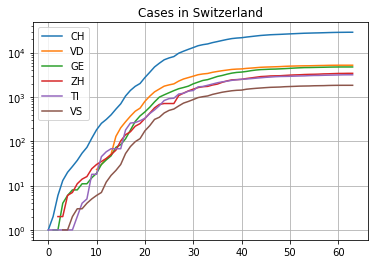

In [37]:
cases[df_summary.index[:6]].plot(logy=True, grid=True, title="Cases in Switzerland")

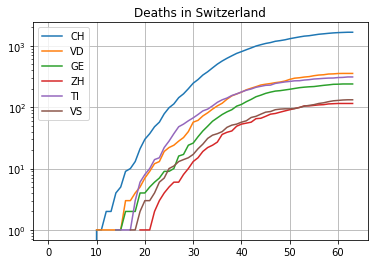

In [38]:
deaths[df_summary.index[:6]].plot(logy=True, grid=True, title="Deaths in Switzerland")

# Analysis by Canton

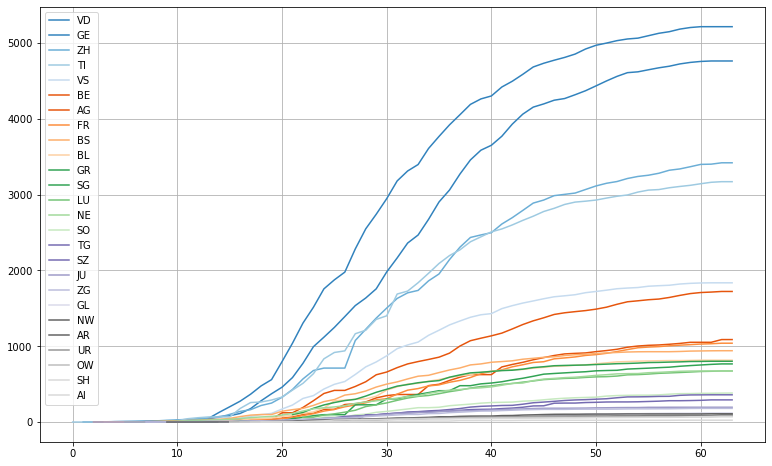

In [39]:
cases[df_summary.index[1:]].plot(figsize=fig_size, grid=True, cmap=color_scheme1)

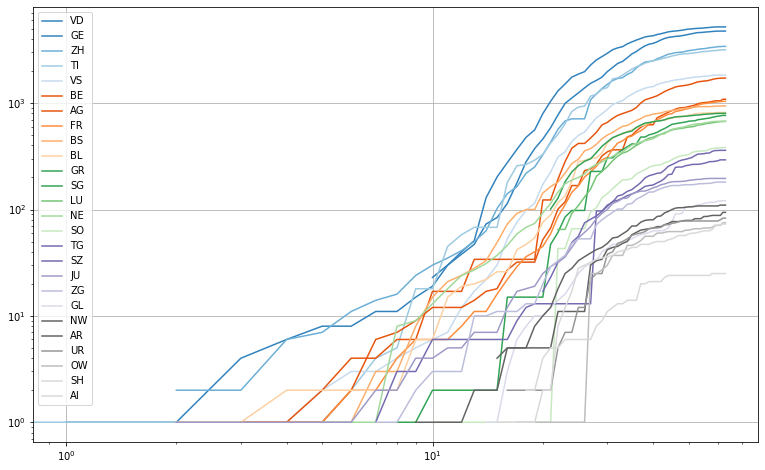

In [40]:
cases[df_summary.index[1:]].plot(figsize=fig_size, logy=True, logx=True, grid=True, cmap=color_scheme1)

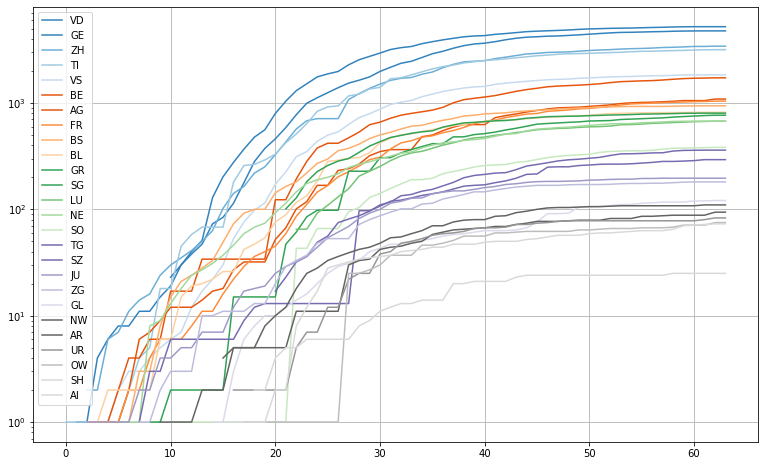

In [41]:
cases[df_summary.index[1:]].plot(figsize=fig_size, logy=True, grid=True, cmap=color_scheme1)

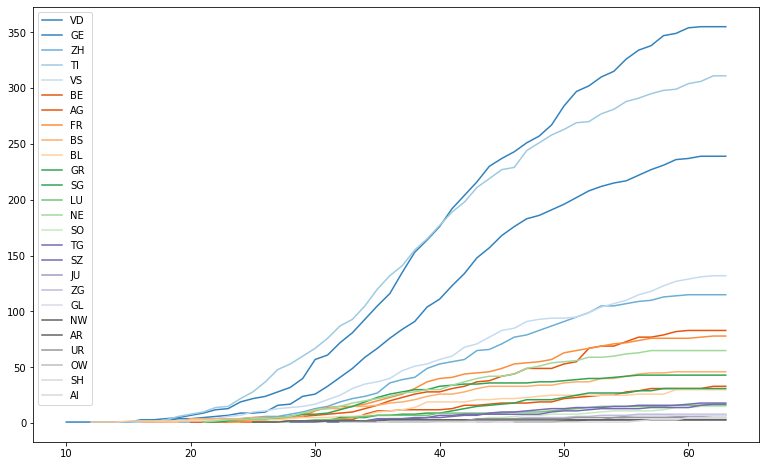

In [42]:
deaths[df_summary.index[1:]].plot(figsize=fig_size, cmap=color_scheme1)

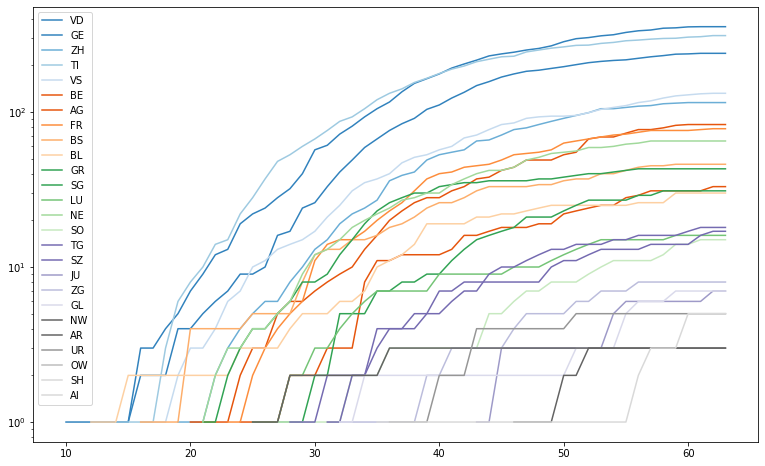

In [43]:
deaths[df_summary.index[1:]].plot(figsize=fig_size, logy=True, cmap=color_scheme1)

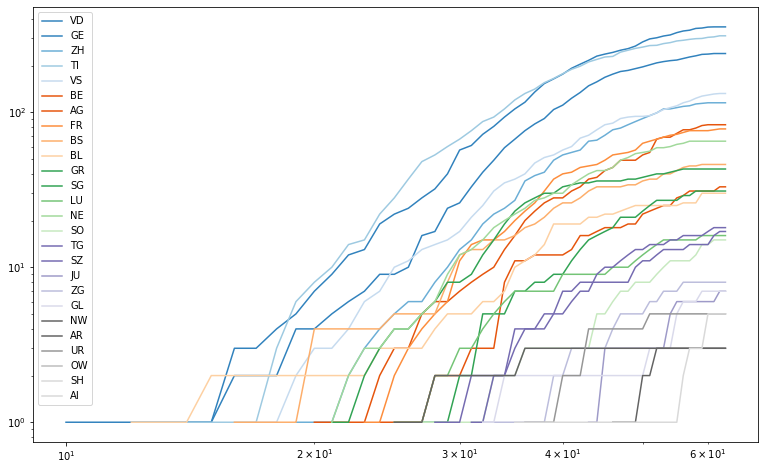

In [44]:
deaths[df_summary.index[1:]].plot(figsize=fig_size, logy=True, logx=True, cmap=color_scheme1)

# Switzerland

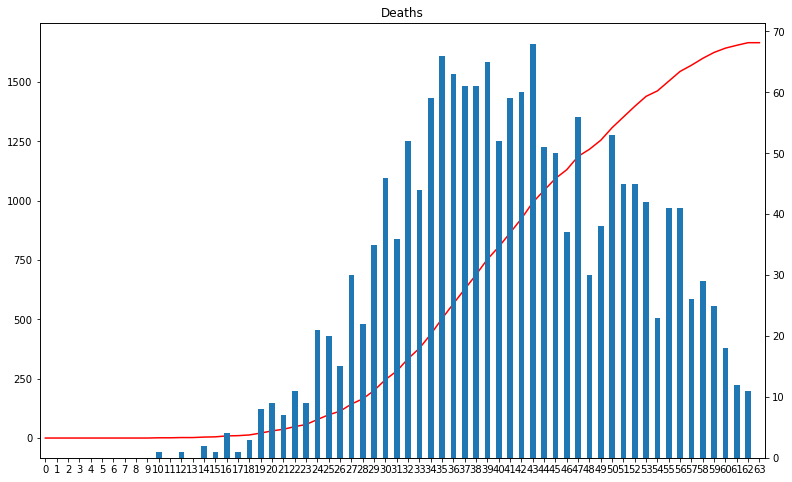

In [45]:
deaths["CH"].plot(figsize=fig_size, color="r", title="Deaths")
daily_deaths["CH"].plot.bar(secondary_y=True, rot=0, figsize=fig_size)

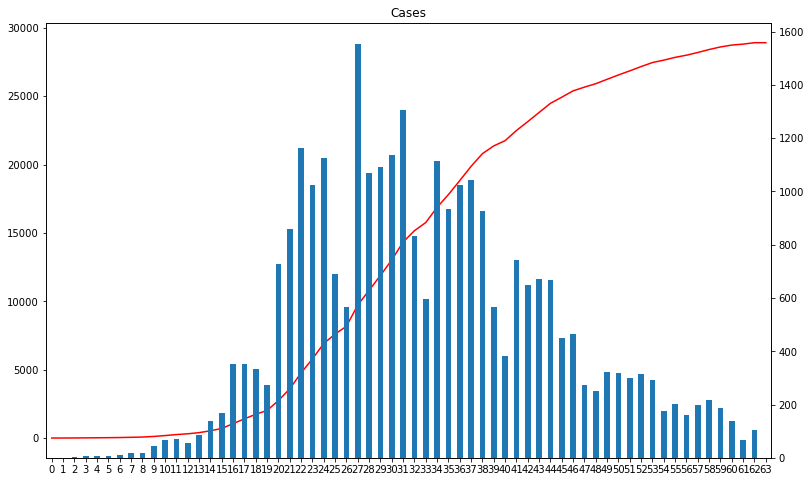

In [46]:
cases["CH"].plot(figsize=fig_size, color="r", title="Cases")
cases_by_day["CH"].plot.bar(secondary_y=True, rot=0, figsize=fig_size)

In [47]:
ch = pd.concat([cases['CH'], deaths['CH']], axis=1)

In [48]:
ch.columns = ["Cases", "Deaths"]

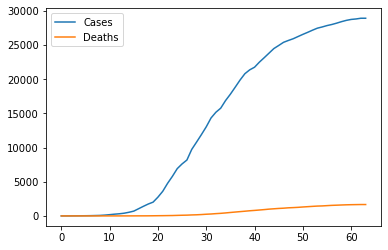

In [49]:
ch.plot()

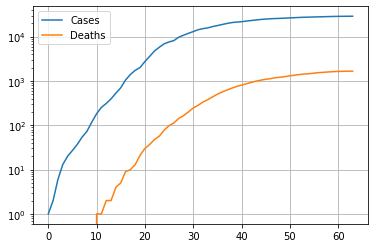

In [50]:
ch.plot(logy=True, grid=True)

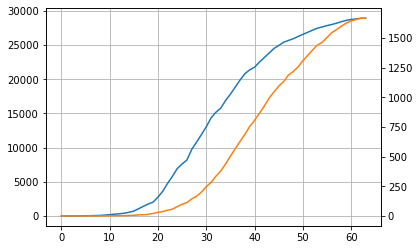

In [51]:
ch["Cases"].plot(grid=True)
ch["Deaths"].plot(secondary_y=True, grid=True)

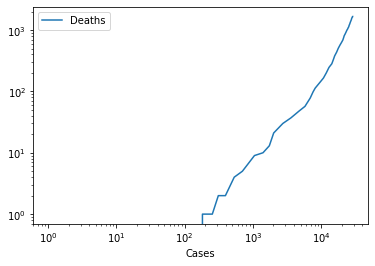

In [52]:
ch.plot(x="Cases", y="Deaths", logx=True, logy=True)

In [53]:
def plot_correlation_matrix(df):
    fig, ax = plt.subplots(figsize=(16, 16))
    im = ax.imshow(df.corr(), cmap="autumn")
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.columns)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(df.columns, fontsize=12)
    ax.set_yticklabels(df.columns, fontsize=12)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_title("Correlation Matrix")
    fig.colorbar(im)
    fig.tight_layout()
    plt.show()


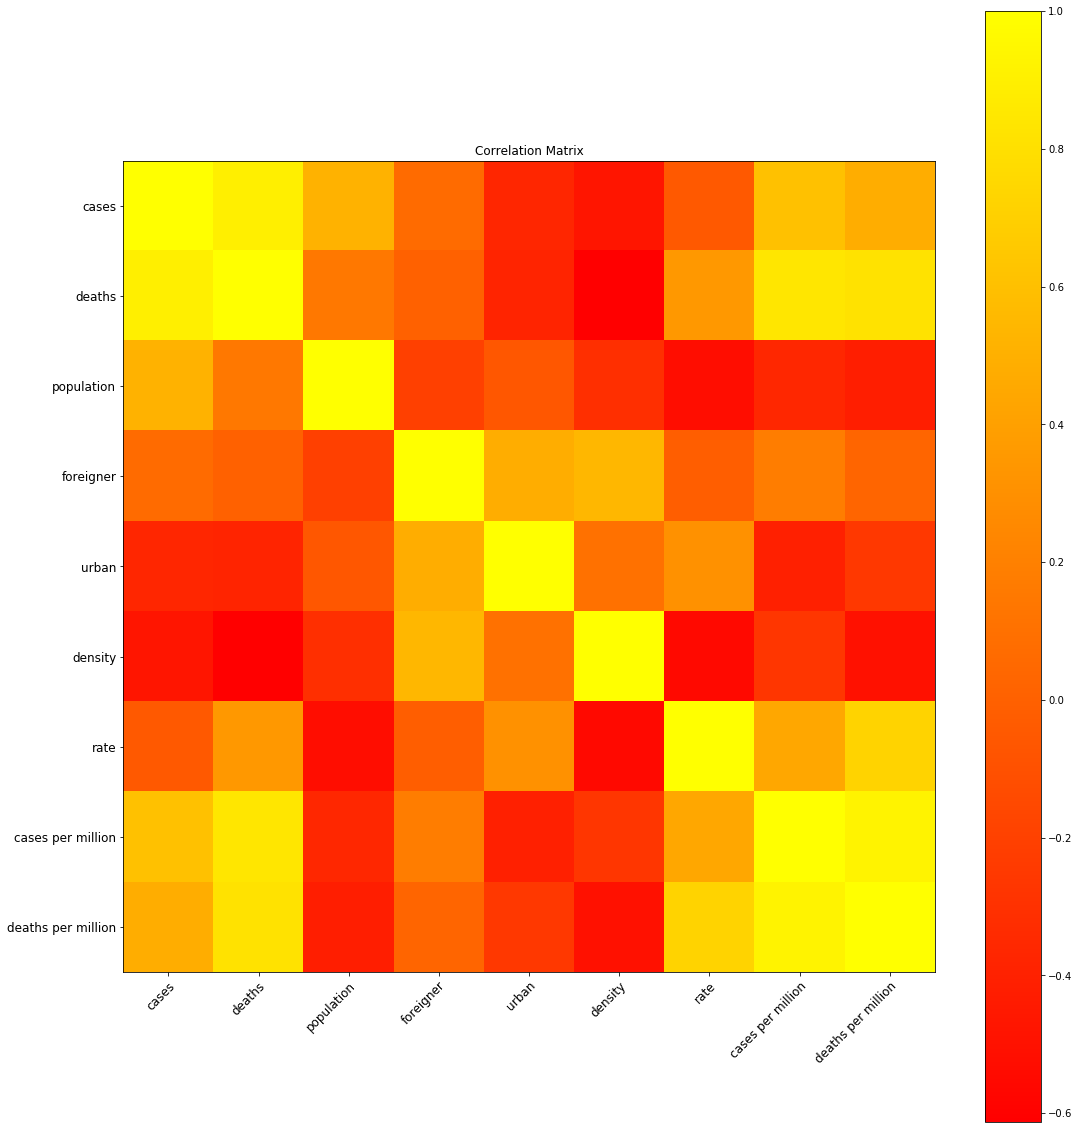

In [54]:
plot_correlation_matrix(df_summary.drop("CH").corr())

In [55]:
corr

,cases,deaths,population,foreigner,urban,density,rate,cases per million,deaths per million
cases,1.000000,0.930908,0.669825,0.641199,0.406195,0.195492,0.319953,0.760658,0.658185
deaths,0.930908,1.000000,0.466662,0.584254,0.360245,0.094635,0.503589,0.846354,0.843336
population,0.669825,0.466662,1.000000,0.325229,0.363197,0.075352,0.032886,0.124589,0.098747
foreigner,0.641199,0.584254,0.325229,1.000000,0.700555,0.608010,0.431209,0.590391,0.514472
urban,0.406195,0.360245,0.363197,0.700555,1.000000,0.357603,0.574898,0.294243,0.359741
density,0.195492,0.094635,0.075352,0.608010,0.357603,1.000000,-0.016133,0.300539,0.122355
rate,0.319953,0.503589,0.032886,0.431209,0.574898,-0.016133,1.000000,0.502631,0.731658
cases per million,0.760658,0.846354,0.124589,0.590391,0.294243,0.300539,0.502631,1.000000,0.915550
deaths per million,0.658185,0.843336,0.098747,0.514472,0.359741,0.122355,0.731658,0.915550,1.000000


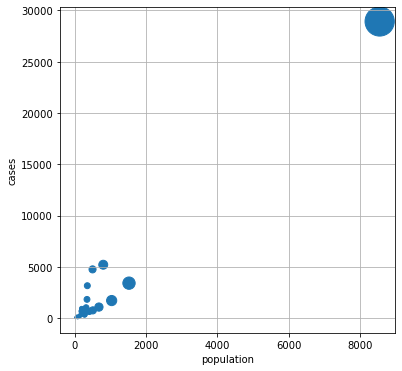

In [56]:
df_summary.plot.scatter(y="cases", 
                    x="population", 
                    s=df_summary["population"] / 10, 
                    grid=True, figsize=(6, 6))

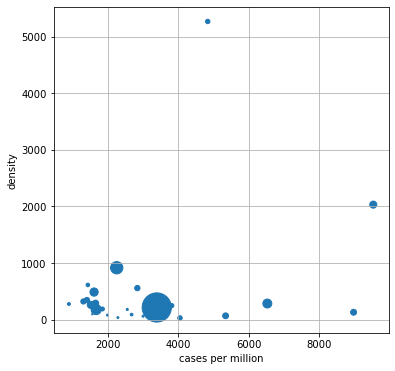

In [57]:
df_summary.plot.scatter(x="cases per million", 
                    y="density",  
                    s=df_summary["population"] / 10, 
                    grid=True, 
                    figsize=(6, 6))

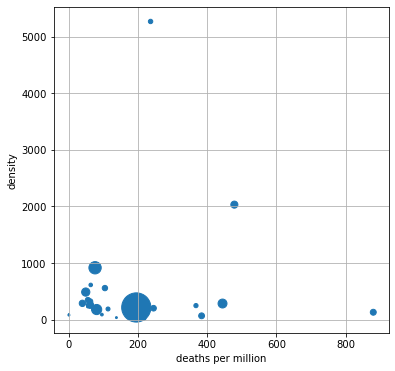

In [58]:
df_summary.plot.scatter(x="deaths per million", 
                    y="density", 
                    s=df_summary["population"] / 10, 
                    grid=True, 
                    figsize=(6, 6))

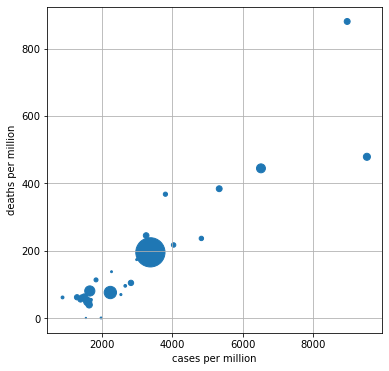

In [59]:
df_summary.plot.scatter(y="deaths per million", 
                    x="cases per million", 
                    s=df_summary["population"] / 10, 
                    grid=True, figsize=(6, 6))

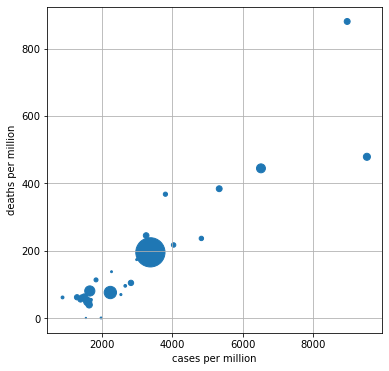

In [60]:
df_summary.plot.scatter(y="deaths per million", 
                    x="cases per million", 
                    s=df_summary["population"] / 10, 
                    grid=True, figsize=(6, 6))

In [61]:
number_of_canton = 15

In [62]:
canton = pd.concat([df_summary[["cases", "deaths"]].drop("CH").iloc[:number_of_canton], 
                pd.DataFrame([df_summary[["cases", "deaths"]].drop("CH").iloc[number_of_canton:].sum(),])])

In [63]:
canton.rename(index={0: 'others'}, inplace=True)

In [64]:
canton.sort_values(by="cases", ascending=False, inplace=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000216B460E548>,
      dtype=object)

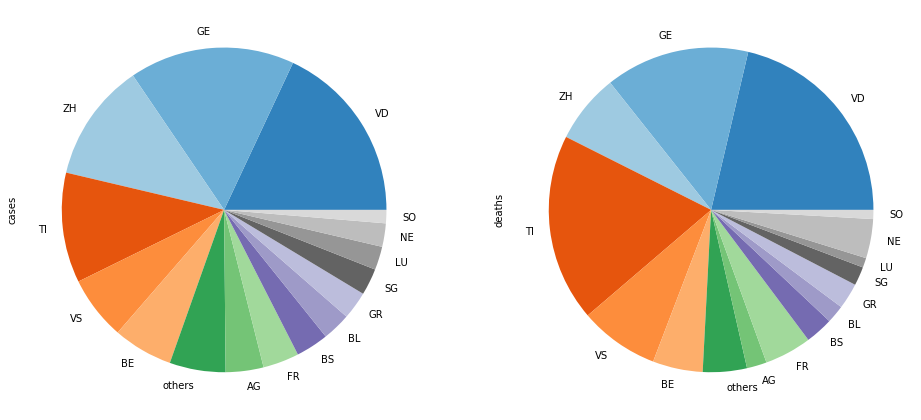

In [65]:
canton.plot.pie(subplots=True, figsize=(16, 8), cmap=plt.cm.get_cmap('tab20c'), legend=False)

In [66]:
df_summary.sort_values(by="cases per million", inplace=True, ascending=False)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000216B46FF148>,
      dtype=object)

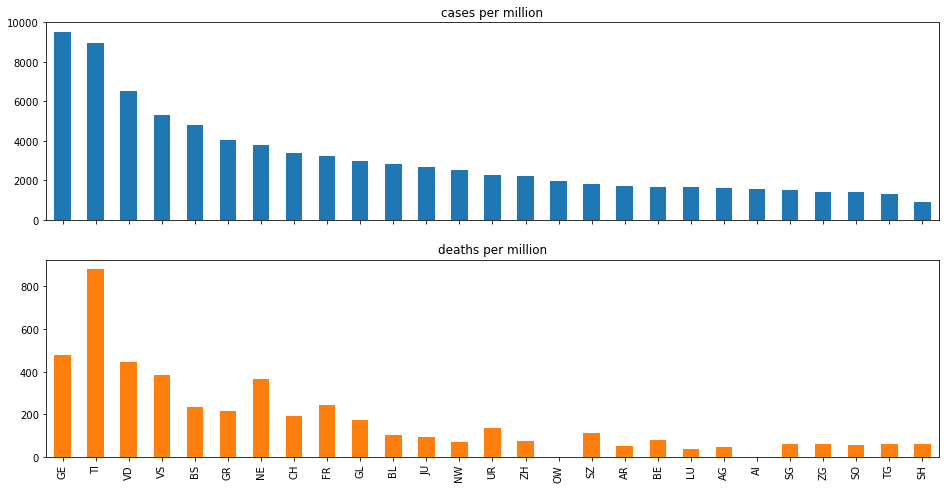

In [67]:
df_summary[["cases per million","deaths per million"]].plot.bar(subplots=True, figsize=(16, 8), legend=False)

In [68]:
from scipy.optimize import curve_fit

In [69]:
def logistic(x, l, k, x0):
    return l / (1 + np.exp(-1 * k * (x -x0)))

In [70]:
xdata = np.linspace(0, 100, 100)

In [71]:
max(ch["Deaths"])

1665.0

In [72]:
popt, pcov = curve_fit(logistic, 
                       ch.index.to_numpy(), 
                       ch["Deaths"].to_numpy(), 
                       bounds=([max(ch["Deaths"]), 0, 0], [max(ch["Deaths"]) *10, 2, 100]))

In [73]:
popt

array([1.69525641e+03, 1.55083607e-01, 4.11260281e+01])

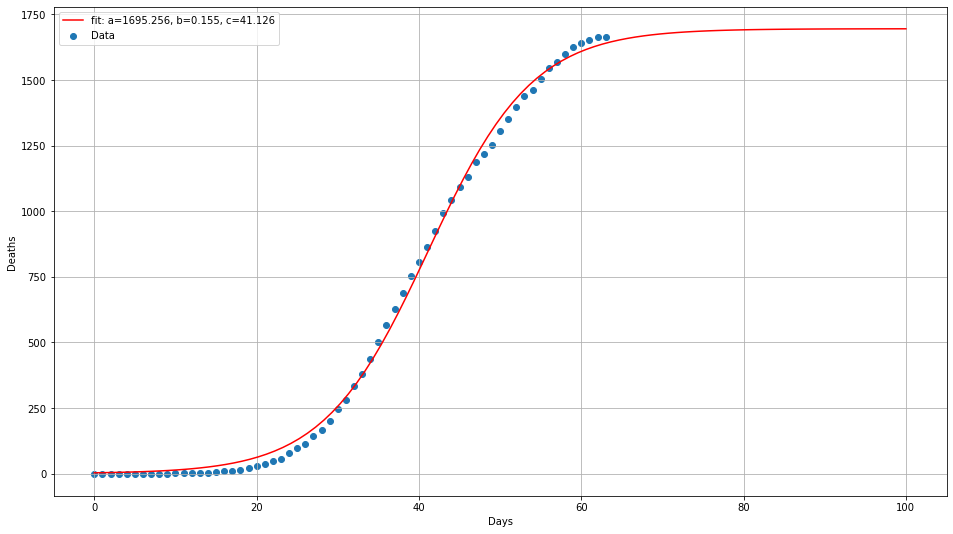

In [74]:
plt.figure(1, figsize=(16, 9))
plt.scatter(ch.index, ch["Deaths"], label="Data")
plt.plot(xdata, logistic(xdata, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.grid(True)
plt.legend()
# plt.show()

In [75]:
popt

array([1.69525641e+03, 1.55083607e-01, 4.11260281e+01])

[2.99130000e+04 1.19597754e-01 3.18878876e+01]


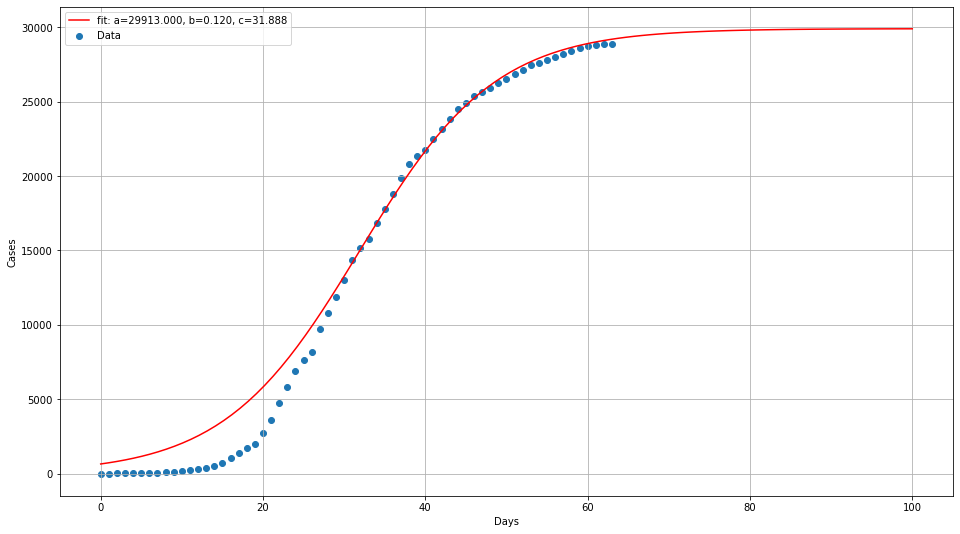

In [76]:
popt, pcov = curve_fit(logistic, 
                       ch[ch["Cases"] > 10000].index, 
                       ch.loc[ch["Cases"] > 10000, "Cases"], 
                       bounds=([max(ch["Cases"]) + 1000, 0, 0], [max(ch["Cases"]) * 10,2, 100]))
print(popt)
plt.figure(1, figsize=(16, 9))
plt.scatter(ch.index, 
            ch["Cases"],
            label="Data")
plt.plot(xdata, logistic(xdata, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel('Days')
plt.ylabel('Cases')
plt.grid(True)
plt.legend()
# plt.show()

In [77]:
pcov

array([[ 2.76693023e+04, -3.93804762e-01,  1.20459471e+01],
       [-3.93804762e-01,  8.15292123e-06, -7.06170398e-05],
       [ 1.20459471e+01, -7.06170398e-05,  1.67411830e-02]])

In [78]:
deaths.columns

Index(['date', 'AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR',
       'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR',
       'VD', 'VS', 'ZG', 'ZH', 'CH'],
      dtype='object')

In [79]:
vd = pd.merge(cases[["date", "VD"]], deaths[["date", "VD"]], how="inner", on="date")

In [80]:
vd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 63
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    64 non-null     datetime64[ns]
 1   VD_x    54 non-null     float64       
 2   VD_y    54 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.0 KB


In [81]:
vd.columns = ["date", "cases", "deaths"]

In [82]:
vd["daily cases"] = vd["cases"].diff()

In [83]:
vd["daily deaths"] = vd["deaths"].diff()

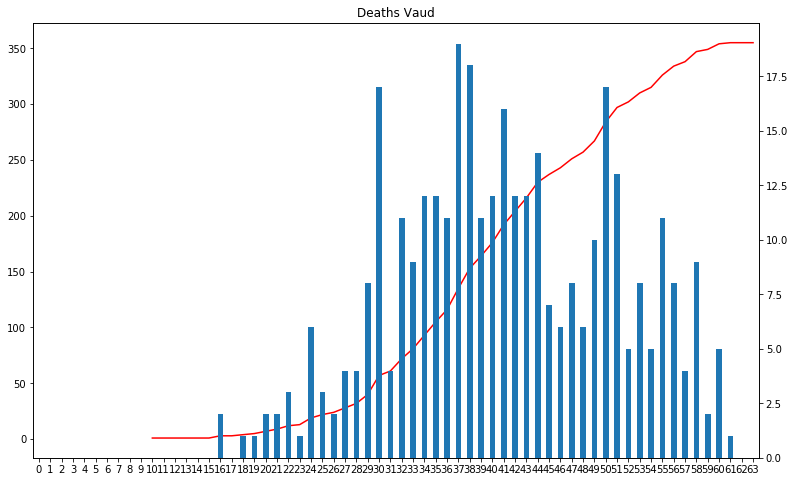

In [84]:
vd["deaths"].plot(figsize=fig_size, color="r", title="Deaths Vaud")
vd["daily deaths"].plot.bar(secondary_y=True, rot=0, figsize=fig_size)

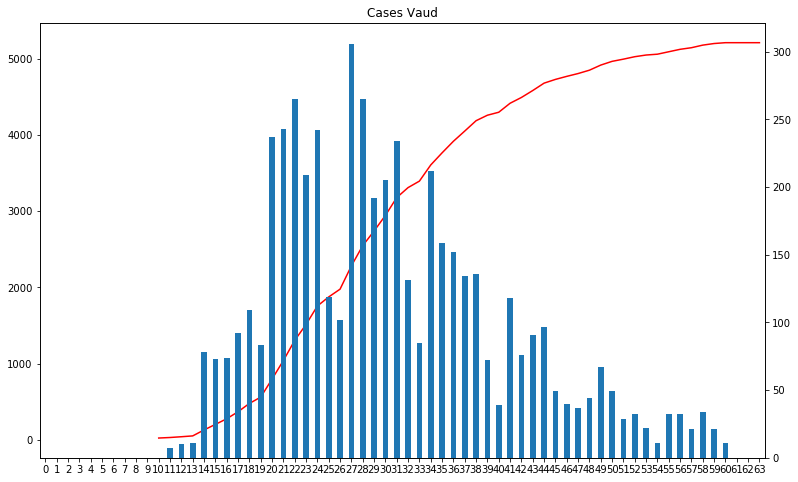

In [85]:
vd["cases"].plot(figsize=fig_size, color="r", title="Cases Vaud")
vd["daily cases"].plot.bar(secondary_y=True, rot=0, figsize=fig_size)

In [86]:
ge = pd.merge(cases[["date", "GE"]], deaths[["date", "GE"]], how="inner", on="date")
ge.columns = ["date", "cases", "deaths"]
ge["daily cases"] = ge["cases"].diff()
ge["daily deaths"] = ge["deaths"].diff()

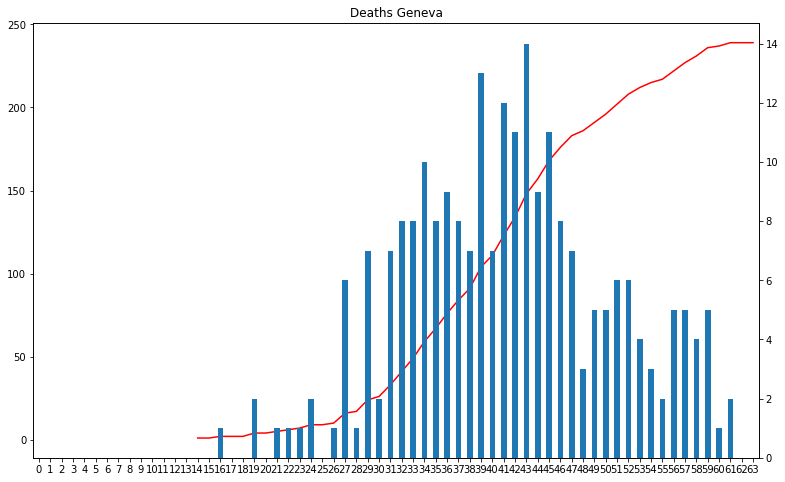

In [87]:
ge["deaths"].plot(figsize=fig_size, color="r", title="Deaths Geneva")
ge["daily deaths"].plot.bar(secondary_y=True, rot=0, figsize=fig_size)

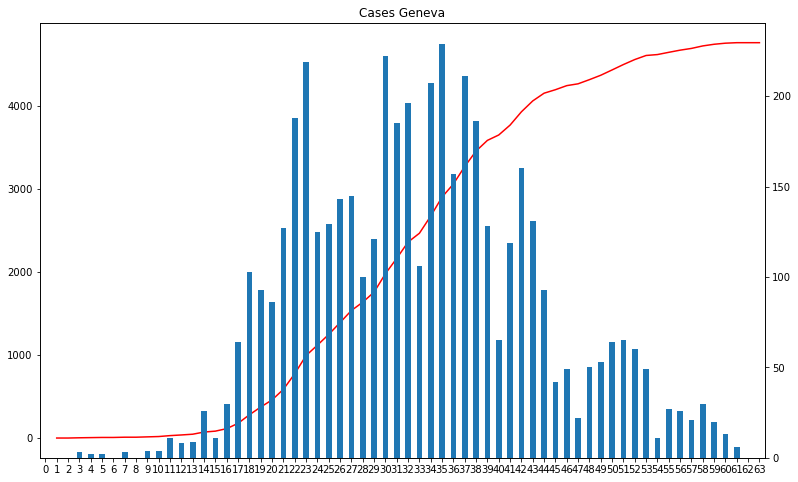

In [88]:
ge["cases"].plot(figsize=fig_size, color="r", title="Cases Geneva")
ge["daily cases"].plot.bar(secondary_y=True, rot=0, figsize=fig_size)

In [89]:
ti = pd.merge(cases[["date", "TI"]], deaths[["date", "TI"]], how="inner", on="date")
ti.columns = ["date", "cases", "deaths"]
ti["daily cases"] = ti["cases"].diff()
ti["daily deaths"] = ti["deaths"].diff()

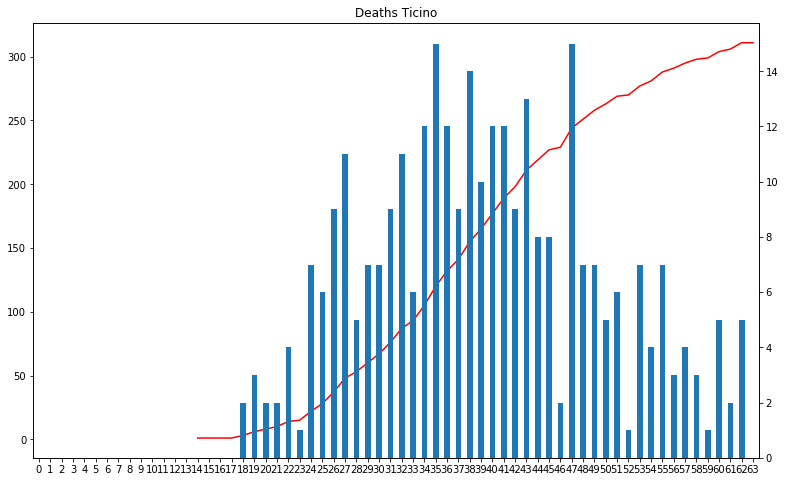

In [90]:
ti["deaths"].plot(figsize=fig_size, color="r", title="Deaths Ticino")
ti["daily deaths"].plot.bar(secondary_y=True, rot=0, figsize=fig_size)

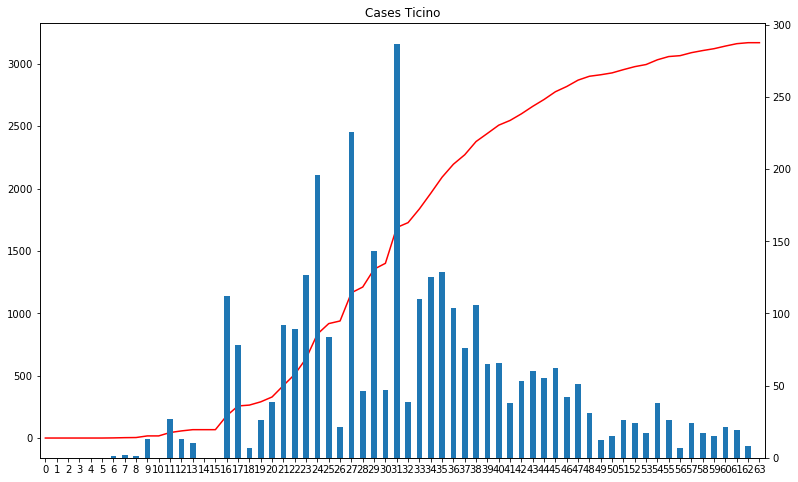

In [91]:
ti["cases"].plot(figsize=fig_size, color="r", title="Cases Ticino")
ti["daily cases"].plot.bar(secondary_y=True, rot=0, figsize=fig_size)